# Shadowing in ERM, multiple runs (Learning Halfspaces)

This script runs the content of ***shadowingERM.ipynb*** multiple times and saves the data in the results folder for statistical purposes.

The interested researcher can slip this notebook and instead just look at ***shadowingERM.ipynb*** to get a quick understanding of how the code works.

In [24]:
import sys
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
import torch
torch.set_default_tensor_type(torch.DoubleTensor)

def tic():
    #Homemade version of matlab tic and toc functions
    import time
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    import time
    if 'startTime_for_tictoc' in globals():
        print(str(time.time() - startTime_for_tictoc))
    else:
        print('Toc: start time not set')

**Tuning parameters**

In [25]:
#the string below describes the experiment to run
details0 = '5_runs_GD_visc_0.3_MNIST_step_1_ODE_RK4_withstep_0.1_nit_20000_reg_0.005'


#select GD or HB
algorithm = 'GD'

#simulation of corresponding ODE : 
#possible are EULER, RK2, RK4 for GD and VERLET for HB
simulation = 'RK4'
h_ode = 1 #simulation stepsize
alpha = 0.3 #viscosity (in case HB)
beta_ode = 1-alpha*h_ode #momentum parameter for VERLET simulation

#algorithm parameters
h_algo = 1
beta_algo = 1-alpha*h_algo #momentum parameter for HB

#link for time variables
ratio_h = round(h_algo/h_ode)

#dataset : possible are IRIS(toy), MNIST, Fashion-MNIST, CIFAR10
dataset = 'Fashion-MNIST'
number_datapoints = 10000

#number of iterations
nit_ode = int(1e3)
nit_algo = int(nit_ode/ratio_h)
runs = 5
subsampling = 1000

#parameters model
lambda_reg = 0.005
add_bias = 1
normalize = 0 

seeds = [71, 28, 56, 80, 65]
# for saving
details = str(runs)+'_runs_'+algorithm+'_visc_'+str(alpha)+'_'+dataset+'_step_'+str(h_algo)+'_ODE_'+simulation+'_withstep_'+str(h_ode)+'_nit_'+str(nit_ode)+'_reg_'+str(lambda_reg)
print(details)

#43 is a lucky seed for 100 images

5_runs_GD_visc_0.3_Fashion-MNIST_step_1_ODE_RK4_withstep_1_nit_1000_reg_0.005


**Dataset**

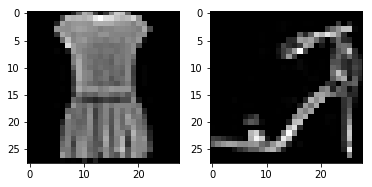

In [26]:
if   dataset == 'IRIS': #toy example
    
    iris = datasets.load_iris()
    iris.target[iris.target != 0] = -1
    iris.target[iris.target == 0] = 1
    iris.target = iris.target.reshape(-1,1)
    Z = torch.from_numpy(iris.data[:, :2])
    y = torch.from_numpy(iris.target).double()
    
else:
    if dataset == 'MNIST':
        train_dataset = torchvision.datasets.MNIST(root='data/data-MNIST', train=True, transform=transforms.ToTensor(),download=True)
        dim_img = 28
    elif dataset == 'Fashion-MNIST':
        train_dataset=torchvision.datasets.FashionMNIST(root='data/data-Fashion-MNIST', train=True, transform=transforms.ToTensor(), download=True)        
        dim_img = 28
    elif dataset == 'CIFAR10':
        trainTransform  = torchvision.transforms.Compose([torchvision.transforms.Grayscale(num_output_channels=1),
                                    torchvision.transforms.ToTensor(), 
                                    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        train_dataset = torchvision.datasets.CIFAR10(root='data/data-CIFAR', train=True, transform=trainTransform,download=True)
        dim_img = 32
    
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=int(len(train_dataset)), shuffle=False)
    images, labels = next(iter(train_loader))
    images = torch.squeeze(images)
    images = images.reshape(-1, dim_img*dim_img).double()
    digit1 = 3 #cats in CIFAR
    digit2 = 5 #dogs in CIFAR
    
    if number_datapoints>=images.shape[0]:
        number_datapoints = images.shape[0]
    nd = int(np.floor(number_datapoints/2))
    
    #first class
    mask1 = (labels == digit1)
    images1 = images[mask1]
    labels1 = labels[mask1]
    Z1 = images1[range(nd),:]
    y1 = labels1[range(nd)].double().reshape(-1,1)
    y1[:] = -1
    
    #second class
    mask2 = (labels == digit2)
    images2 = images[mask2]
    labels2 = labels[mask2]
    Z2 = images2[range(nd),:]
    y2 = labels2[range(nd)].double().reshape(-1,1)
    y2[:] = 1
    
    #merging to get dataset
    Z=torch.cat((Z1,Z2), 0)
    y=torch.cat((y1,y2), 0)
    
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(Z1[0,:].reshape(dim_img,dim_img),cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(Z2[0,:].reshape(dim_img,dim_img),cmap='gray')    
    plt.show()
    
if normalize:
    m=torch.mean(Z,dim=0)
    s=torch.std(Z,dim=0)
    for j in range(Z.shape[1]):
        if s[j]==0:
            Z[:,j] = 0
        else:
            Z[:,j] = (Z[:,j]-m[j])/s[j]
    
if add_bias:
    Z=torch.cat((Z,1+0*y), 1)

**Cost function (Sigmoid loss)**

In [27]:
def loss(x):
   l = lambda_reg*x.t()@x + torch.sigmoid(y*(Z@x)).mean()
   return l

**Running Algorithm**

In [28]:
#outer loop variables for comparison
perc_res_all = np.zeros([nit_algo,runs])
accuracy_algo_all = np.zeros([nit_algo,runs])
accuracy_ode_all = np.zeros([nit_algo,runs])
loss_hist_algo_all = np.zeros([nit_algo,runs])
loss_hist_ode_all = np.zeros([nit_algo,runs])

tic()
for e in range(runs):
    seed = seeds[e]
    print(seed)
    
    #BEGIN ALGORITHM 
    torch.manual_seed(seed)
    x = torch.randn([Z.shape[1],1],requires_grad=True)
    x_hist_algo = np.zeros([Z.shape[1],nit_algo])
    loss_hist_algo = np.zeros([nit_algo,])
    
    for k in range(nit_algo):
        #computing the loss
        l =  loss(x)
        #saving to history
        x_hist_algo[:,k] =  np.squeeze(x.data.numpy())
        loss_hist_algo[k] = l.data.numpy()

        #update for GD
        if algorithm == 'GD':
            l.backward() #backprop
            with torch.no_grad():
                x -= h_algo*x.grad
            x.grad.data.fill_(0)

        #update for HB
        elif algorithm == 'HB':
            l.backward() #backprop
            with torch.no_grad():
                if k==0:
                    momentum = 0
                else:
                    momentum = torch.from_numpy(x_hist_algo[:,k]-x_hist_algo[:,k-1]).reshape(-1,1)
                x += -(h_algo*h_algo)*x.grad + beta_algo*momentum 
            x.grad.data.fill_(0)

        else: sys.exit('SELECT A VALID ALGORITHM (GD or HB)!!')
        #END ALGORITHM

    #BEGIN ODE
    torch.manual_seed(seed)
    x = torch.randn([Z.shape[1],1],requires_grad=True)
    y1 = torch.randn([Z.shape[1],1],requires_grad=True) #needed for Runge Kutta
    y2 = torch.randn([Z.shape[1],1],requires_grad=True) #needed for Runge Kutta
    y3 = torch.randn([Z.shape[1],1],requires_grad=True) #needed for Runge Kutta
    x_hist_ode = np.zeros([Z.shape[1],nit_ode])
    loss_hist_ode = np.zeros([nit_ode,])
    for k in range(nit_ode):
        #computing the loss
        l =  loss(x)

        #saving to history
        x_hist_ode[:,k] =  np.squeeze(x.data.numpy())
        loss_hist_ode[k] = l.data.numpy()

        #performing numerical integration
        if algorithm == 'GD':
            if simulation == 'EULER':
                #Euler Method = GD (1 backpropagation)
                #     to simulate dx/dt = f(x)     
                #     k1 = h * f(x)
                #     x = x + k1
                l.backward() 
                with torch.no_grad(): 
                    k1 = -h_ode*x.grad
                    x += k1
                    x.grad.data.fill_(0)    


            elif simulation == 'RK2':
                #second order Runge Kutta (2 backpropagations)
                #     to simulate dx/dt = f(x)
                #     k1 = h * f(x)
                #     k2 = h * f(x + k1)
                #     x = x + (k1 + k2) / 2
                l.backward() 
                with torch.no_grad(): 
                    k1 = -h_ode*x.grad
                    y1 = x+k1
                    x.grad.data.fill_(0)
                    y1.requires_grad=True
                l =  loss(y1)  
                l.backward() 
                with torch.no_grad():
                    k2 = -h_ode*y1.grad
                    x += (k1 + k2) / 2
                    y1.grad.data.fill_(0)


            elif simulation == 'RK4':
                #forth order Runge Kutta (4 backpropagations)
                #     to simulate dx/dt = f(x)     
                #     k1 = h * f(x)
                #     k2 = h * f(x + 0.5 * k1)
                #     k3 = h * f(x + 0.5 * k2)
                #     k4 = h * f(x + k3)
                #     x = x + (k1 + k2 + k2 + k3 + k3 + k4) / 6
                l.backward() 
                with torch.no_grad(): 
                    k1 = -h_ode*x.grad
                    y1 = x+0.5*k1
                    x.grad.data.fill_(0)
                    y1.requires_grad=True
                l =  loss(y1)
                l.backward()
                with torch.no_grad():
                    k2 = -h_ode*y1.grad
                    y2 = x+0.5*k2
                    y1.grad.data.fill_(0)
                    y2.requires_grad=True
                l =  loss(y2)
                l.backward() 
                with torch.no_grad():
                    k3 = -h_ode*y2.grad
                    y3 = x+k3
                    y2.grad.data.fill_(0)
                    y3.requires_grad=True
                l =  loss(y3)  
                l.backward() 
                with torch.no_grad():
                    k4 = -h_ode*y3.grad
                    x += (k1 + k2 + k2 + k3 + k3 + k4) / 6
                    y3.grad.data.fill_(0)

            else: sys.exit('SELECT A VALID INTEGRATOR (EULER, RK2, RK4)!!')


        elif algorithm == 'HB':
            if simulation == 'VERLET':
                l.backward() #backprop
                with torch.no_grad():
                    if k==0:
                        momentum = 0
                    else:
                        momentum = torch.from_numpy(x_hist_ode[:,k]-x_hist_ode[:,k-1]).reshape(-1,1)
                    x += -(h_ode*h_ode)*x.grad + beta_ode*momentum 
                    x.grad.data.fill_(0)
            else: sys.exit('SELECT A VALID INTEGRATOR (ONLY VERLET AVAILABLE)!!')

        else: sys.exit('SELECT A VALID ALGORITHM (GD or HB)!!')
        #END ODE

    x_hist_ode = x_hist_ode[:,::ratio_h]
    loss_hist_ode = loss_hist_ode[::ratio_h]

    #computing shadowing radius
    res = x_hist_algo-x_hist_ode
    perc_res = 100*np.linalg.norm(res, axis=0)/np.linalg.norm(x_hist_ode, axis=0)

    #computing accuracy ode
    ZZ = Z.numpy()
    yy = np.squeeze(y.numpy())
    prediction_ode = ZZ@x_hist_ode
    accuracy_ode = 0*prediction_ode[0,:]
    for j in range(len(accuracy_ode)):
        idxpos = prediction_ode[:,j]>=0
        idxneg = prediction_ode[:,j]<0
        prediction_ode[idxpos,j] = 1
        prediction_ode[idxneg,j] = -1        
        accuracy_ode[j] = 100*(np.sum(np.abs(prediction_ode[:,j] - yy))/2)/prediction_ode.shape[0]

    #computing accuracy algorithm
    prediction_algo = ZZ@x_hist_algo
    accuracy_algo = 0*prediction_algo[0,:]
    for j in range(len(accuracy_algo)):
        idxpos = prediction_algo[:,j]>=0
        idxneg = prediction_algo[:,j]<0
        prediction_algo[idxpos,j] = 1
        prediction_algo[idxneg,j] = -1        
        accuracy_algo[j] = 100*(np.sum(np.abs(prediction_algo[:,j] - yy))/2)/prediction_algo.shape[0]
        
    ########## END OF SINGLE COMPUTATION, SAVING ########
    perc_res_all[:,e] = perc_res
    accuracy_algo_all[:,e] = accuracy_algo
    accuracy_ode_all[:,e] = accuracy_ode
    loss_hist_algo_all[:,e] = loss_hist_algo
    loss_hist_ode_all[:,e] = loss_hist_ode
toc()

71
28
56
80
65
113.75582981109619


**Plotting**

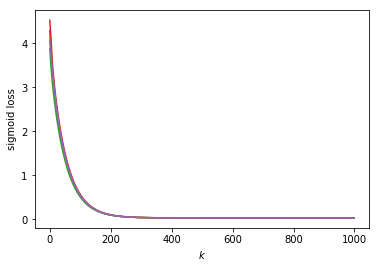

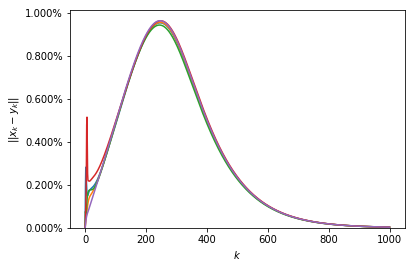

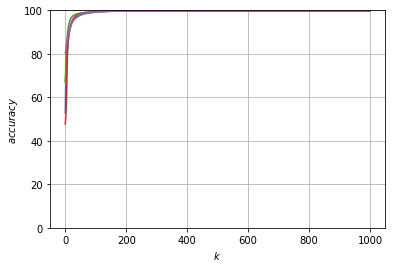

In [29]:
fig0=plt.figure()
#plt.plot(loss_hist_algo_all)
plt.plot(loss_hist_ode_all)
plt.xlabel('$k$',fontsize=10)
plt.ylabel('sigmoid loss',fontsize=10)
#fig0.savefig('loss.eps', format='eps', dpi=1000)
plt.show()

fig1=plt.figure()
plt.plot(perc_res_all)
plt.xlabel('$k$',fontsize=10)
plt.ylabel('$||x_k-y_k||$',fontsize=10)
plt.ylim(0,1.05*np.max(perc_res_all))
plt.gca().set_yticklabels(['{:.3f}%'.format(x) for x in plt.gca().get_yticks()]) 
#fig1.savefig('shad.eps', format='eps', dpi=1000)
plt.show()

fig2=plt.figure()
#plt.plot(accuracy_algo_all)
plt.plot(accuracy_ode_all)
plt.xlabel('$k$',fontsize=10)
plt.ylabel('$accuracy$',fontsize=10)
plt.ylim(0,100)
plt.grid(True)
#fig2.savefig('acc.eps', format='eps', dpi=1000)
plt.show()

In [30]:
res

array([[ 0.00000000e+00, -2.87773932e-05, -5.69806727e-05, ...,
        -1.32191718e-06, -1.31004358e-06, -1.29827533e-06],
       [ 0.00000000e+00, -3.93394437e-05, -7.78940574e-05, ...,
        -1.80706917e-06, -1.79083788e-06, -1.77475059e-06],
       [ 0.00000000e+00, -9.28596668e-06, -1.83868937e-05, ...,
        -4.25478419e-07, -4.21655791e-07, -4.17867087e-07],
       ...,
       [ 0.00000000e+00,  1.11996134e-05,  2.19433118e-05, ...,
         2.88621793e-07,  2.85952436e-07,  2.83307499e-07],
       [ 0.00000000e+00,  4.40697731e-05,  8.73217750e-05, ...,
         2.04306010e-06,  2.02473694e-06,  2.00657608e-06],
       [ 0.00000000e+00, -5.73184303e-04, -1.08997823e-03, ...,
        -1.65125323e-06, -1.63516908e-06, -1.61924013e-06]])

In [31]:

details


'5_runs_GD_visc_0.3_Fashion-MNIST_step_1_ODE_RK4_withstep_1_nit_1000_reg_0.005'

In [32]:
torch.save(loss_hist_ode_all,'results/loss_'+details+'.pt')
torch.save(perc_res_all,'results/perc_'+details+'.pt')